# Customer Segmentation Analysis

In this notebook I will demonstrate how to perform customer segmentation analysis using kmeans algorithm

In [19]:
from math import pi
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot
sns.set_style('darkgrid')

import utils as utils

In [18]:
!pip install yellowbrick plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 6.4 MB/s eta 0:00:0000:0100:01


In [4]:
from yellowbrick.cluster import SilhouetteVisualizer

## Load the dataset and use only the data from latest year

In [5]:
#df = pd.read_excel('data/Online Retail.xlsx')
#pd.to_pickle(df, 'data/all_data.pkl')

df = pd.read_pickle('data/all_data.pkl')
df.dropna(axis=0, inplace=True, how='any')
end_date = df['InvoiceDate'].max()
start_date = end_date - pd.to_timedelta(364, unit='d')
df_rfm = df[(df['InvoiceDate'] >= start_date) & (df['InvoiceDate'] <= end_date)]
df_rfm.to_pickle('data/last_year_data.pkl')

## calculate a total sum value for each transaction

There are some transactions in the dataset with quantity less than zero, we are going to drop those transactions from this analysis for now.

In [22]:
df_rfm = pd.read_pickle('data/last_year_data.pkl')
df_rfm['TotalSum'] = df_rfm['Quantity'] * df_rfm['UnitPrice']
df_rfm = df_rfm.drop(df_rfm.query("Quantity < 0").index)

## create a dataframe with the useful RFM data for later analysis

In [23]:
end_date = df_rfm['InvoiceDate'].max()
snapshot_date = end_date + timedelta(days=1)
df_rfm = df_rfm.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
df_rfm.rename(columns={'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetarySum'},
                  inplace=True)
df_rfm = df_rfm.drop(df_rfm[df_rfm.MonetarySum == 0].index)
df_cleaned = df_rfm.copy()

In [24]:
df_cleaned.head()

,Recency,Frequency,MonetarySum
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,151,3598.21
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


## Log transform the data for kmeans clustering

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.9/site-packages/seaborn/di

,Recency,Frequency,MonetarySum
CustomerID,,,
12346.0,5.786897,0.000000,11.253942
12347.0,0.693147,5.017280,8.188192
12348.0,4.317488,3.433987,7.494007
12349.0,2.944439,4.290459,7.471676
12350.0,5.736572,2.833213,5.812338


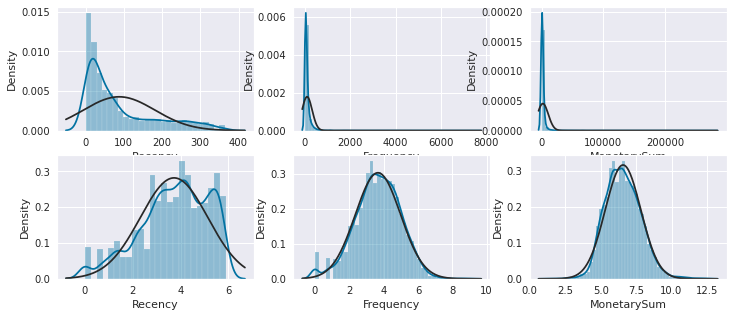

In [25]:
f, axes = plt.subplots(2, 3, figsize=(12, 5))
sns.distplot(df_rfm['Recency'], fit=norm, ax=axes[0, 0])
sns.distplot(df_rfm['Frequency'], fit=norm, ax=axes[0, 1])
sns.distplot(df_rfm['MonetarySum'], fit=norm, ax=axes[0, 2])

df_rfm['Recency'] = np.log(df_rfm['Recency'])
df_rfm['Frequency'] = np.log(df_rfm['Frequency'])
df_rfm['MonetarySum'] = np.log(df_rfm['MonetarySum'])
assert len(df_rfm.index[np.isinf(df_rfm).any(1)]) == 0, 'inf was found in data'

sns.distplot(df_rfm['Recency'], fit=norm, ax=axes[1, 0])
sns.distplot(df_rfm['Frequency'], fit=norm, ax=axes[1, 1])
sns.distplot(df_rfm['MonetarySum'], fit=norm, ax=axes[1, 2])
df_rfm.head()

## Standardize data

In [28]:
df_rfm_norm = (df_rfm - df_rfm.mean()) / df_rfm.std()
df_rfm_norm.describe()

,Recency,Frequency,MonetarySum
count,4.261000e+03,4.261000e+03,4.261000e+03
mean,-1.339708e-14,-1.632539e-14,4.146153e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.633827e+00,-2.784661e+00,-4.183510e+00
25%,-6.325725e-01,-6.334237e-01,-6.836459e-01
50%,1.294501e-01,3.502602e-02,-5.832702e-02
75%,8.204957e-01,6.966700e-01,6.542867e-01
max,1.531657e+00,4.006373e+00,4.748219e+00


## Run KMeans algo and save the silhouette scores for plot

No. Clusters: 2, Silhouette Score: 0.394, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.302, Change from Previous Cluster: -0.092
No. Clusters: 4, Silhouette Score: 0.303, Change from Previous Cluster: 0.001
No. Clusters: 5, Silhouette Score: 0.279, Change from Previous Cluster: -0.024
No. Clusters: 6, Silhouette Score: 0.277, Change from Previous Cluster: -0.002
No. Clusters: 7, Silhouette Score: 0.262, Change from Previous Cluster: -0.015
No. Clusters: 8, Silhouette Score: 0.26, Change from Previous Cluster: -0.002
No. Clusters: 9, Silhouette Score: 0.256, Change from Previous Cluster: -0.004
No. Clusters: 10, Silhouette Score: 0.261, Change from Previous Cluster: 0.005


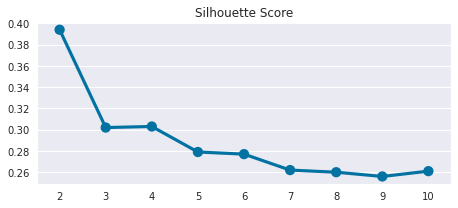

In [30]:
cluster_list = []
km_sil_score = []

start = 2
end = 11
for n_clusters in range(start, end):

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(df_rfm_norm)

    silhouette_avg = round(silhouette_score(df_rfm_norm, labels, random_state=42), 3)

    # Append score to lists
    km_sil_score.append(silhouette_avg)
    cluster_list.append(n_clusters)

    print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
        n_clusters,
        silhouette_avg,
        (km_sil_score[n_clusters - start] - km_sil_score[n_clusters - start - 1]).round(3)))

    if n_clusters == end - 1:
        plt.figure(figsize=(6.47, 3))

        plt.title('Silhouette Score')
        sns.pointplot(x=cluster_list, y=km_sil_score)
        plt.savefig('silhouette_score.png', format='png', dpi=1000)
        plt.tight_layout()
        plt.show()

## Visualize the clusters for different n = 3, 4, 5, 6

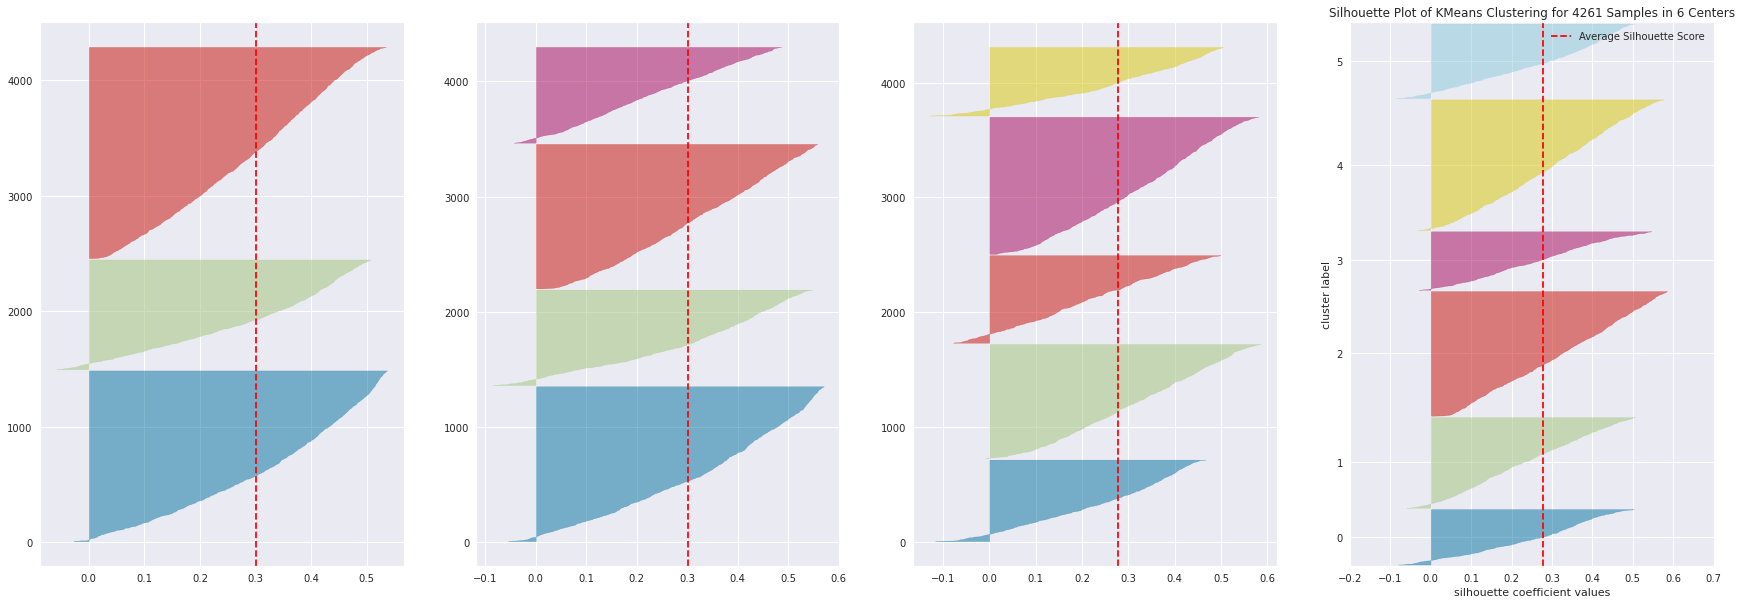

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4261 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
f, axes = plt.subplots(1, 4, figsize=(30, 10))
for n in [3, 4, 5, 6]:
    model = KMeans(n, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[n-3])
    visualizer.fit(df_rfm_norm)
visualizer.show()

In [42]:
def run_kmeans(df, clusters_number):
    kmeans = KMeans(n_clusters=clusters_number, random_state=42)
    kmeans.fit(df)

    cluster_labels = kmeans.labels_
    df_new = df.assign(Cluster=cluster_labels)

    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)

    plt.figure(figsize=(16, 16))
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new, cluster_labels

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



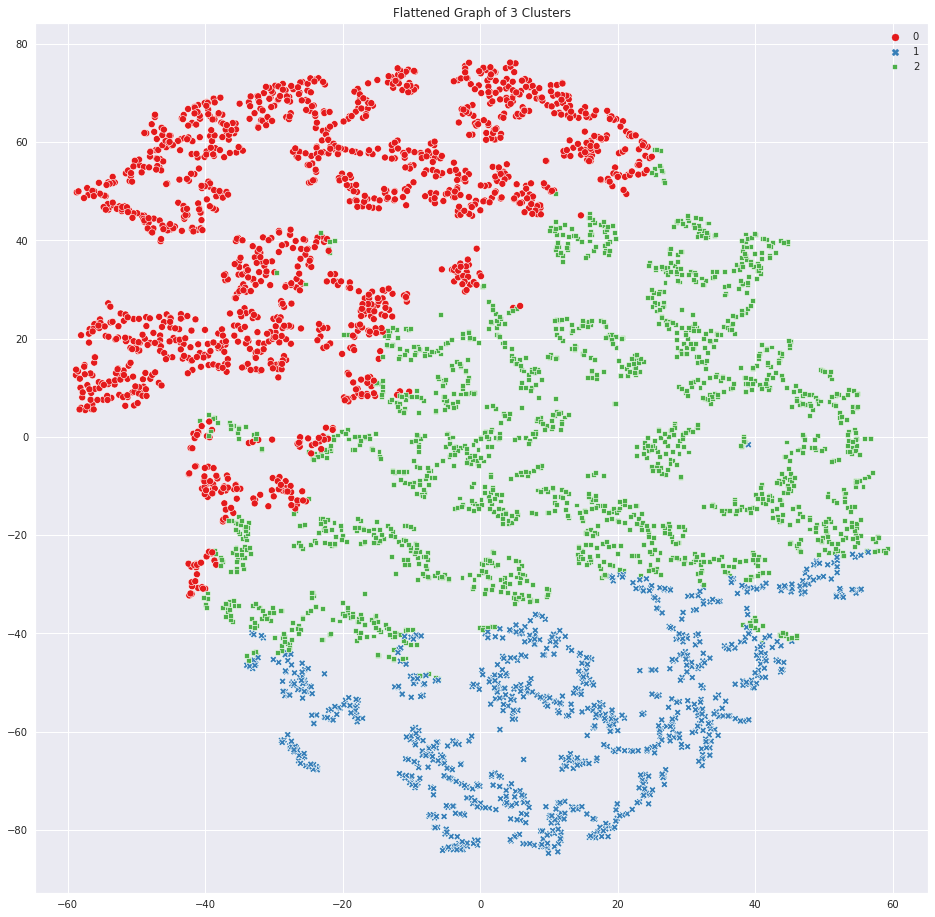

In [43]:
df_new, labels = run_kmeans(df_rfm_norm, 3)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



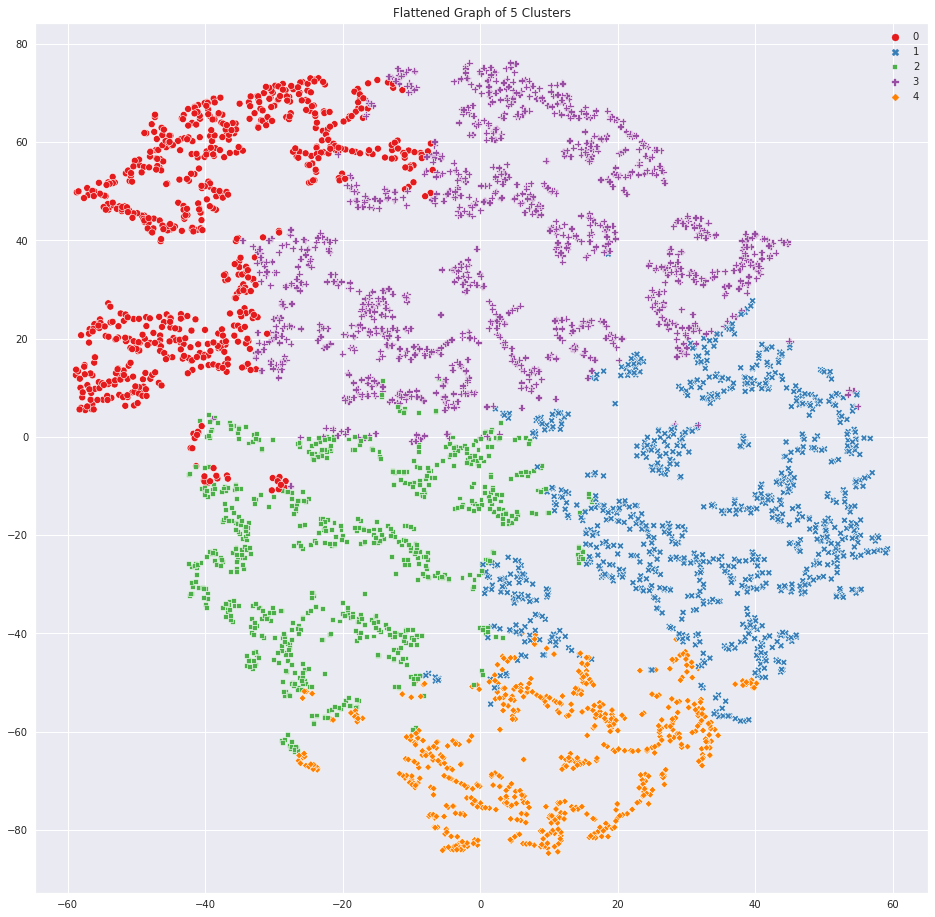

In [44]:
df_new, labels = run_kmeans(df_rfm_norm, 5)

In [45]:
# check the stats in each cluster
df_cleaned['Cluster'] = labels
df = df_cleaned.groupby('Cluster').agg({'Recency': 'mean',
                                        'Frequency': 'mean',
                                        'MonetarySum': ['mean', 'count']}).round(2)
df.head()

Recency Frequency MonetarySum      
           mean      mean        mean count
Cluster                                    
0        160.61      7.27      195.51   710
1         57.66    114.46     2121.40   996
2         16.45     41.96      643.47   763
3        154.00     31.48      534.47  1194
4          8.44    324.05     8692.46   598

## Relative importance heatmap of RFM attributes when cluster n=3

<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='Cluster'>

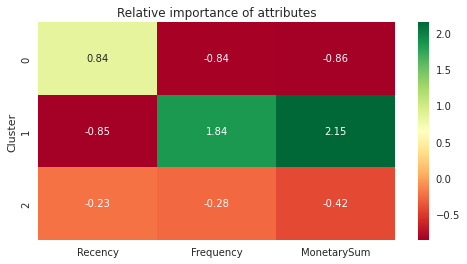

In [35]:
# Calculate average RFM values for each cluster
cluster_avg = df_cleaned.groupby('Cluster').mean()
population_avg = df_cleaned.drop('Cluster', axis=1).mean()
relative_importance = cluster_avg / population_avg - 1
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='RdYlGn')

## Snake plot for the 3 clusters

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'RFM Snake Plot'}, xlabel='Attribute', ylabel='Value'>

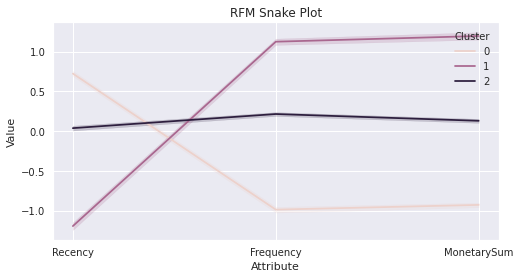

In [36]:
df_normalized = pd.DataFrame(df_rfm_norm, columns=['Recency', 'Frequency', 'MonetarySum'])
df_normalized['ID'] = df_cleaned.index
df_normalized['Cluster'] = labels
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'MonetarySum'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

plt.figure(figsize=(8, 4))
plt.title('RFM Snake Plot')
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

## Conclusion

### In the snake plot we can see that:

- Cluster 1 are loyal customers who have been to store recently and frequently, and they spend significantly more than the other clusters of customers
- Cluster 0 are customers who came to store a while back and have not frequent since, and they spend significant less than the other clusters
- Cluster 2 are customers whose characteristics are in between cluster 0 and cluster 1.

Therefore marketing promotions and customer retargeting strategies can be adjusted accordingly to this newly obtained info about the customers